In [9]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
import datetime
from scipy.stats import norm, kstest

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
####################################################################################
#    Aggregates SNR (.dat), latency (.dat), and ROI photos (png)
#            scraped from PhotoZ
#    Given ROI files in format slice#_rois.dat 
# 8/23/23 We want to add:
#     Take into account the RELATIVE STIM LOCATION within every barrel. Does velocity depend on distance from stimulating location?
#            New column: distance (um) from stim loc to relevant barrel pair boundary (1:2)
#            New column: distance (um) from stim loc to relevant barrel pair boundary (2:3)
#
#     METHOD
#         To calculate stim location to boundary, take these files produced by MovieMaker2.ipynb:
#             electrode.dat
#             corners_layer.dat
#             corners_barrel.dat
#         Calculate: Distance to lower barrel, distance to higher barrel,
#                    Distance to lower layer, distance to higher layer
#                       (if applicable for each)
####################################################################################

In [10]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
# data_dir = 'C:/Users/jjudg/Downloads/'
cell_type_prefix = 'scnn1a'
csv_prefix = cell_type_prefix + '_all_slices-final.csv'

# load the all-data CSV dir
df = pd.read_csv(data_dir + csv_prefix)
df = pd.DataFrame(df)
df = df[df["Exclude Reason"].isnull()]

# filter to only rows with a numerical Medial entry
df = df[pd.to_numeric(df['Most Medial Barrel'], errors='coerce').notnull()]
df

,Date,Slice/Loc/Rec,Slice Edge,Most Medial Barrel,Medial Dir,Slice Location,Stim Location,Stim Barrel,L4 barrel 1 Latency,L4 barrel 2 Latency,...,abs(delta 1),abs(delta 2),Distance to Barrel 1,Distance to Barrel 2,Distance to Layer n1,Distance to Layer n2,Distance to Barrel A,Distance to Barrel B,Distance to Layer nA,Distance to Layer nB
78,9/7/2023,01_01_06,down,1.0,right,Posterior,L4 Barrel 3,3.0,53.0759,51.7804,...,NaN,NaN,NaN,NaN,NaN,NaN,122.707482,162.175515,299.607853,56.903902
79,9/7/2023,01_02_03,down,1.0,right,Posterior,L4,2.0,51.3798,50.8461,...,NaN,NaN,NaN,NaN,NaN,NaN,100.126320,32.581904,128.666263,142.752381
80,9/7/2023,02_01_05,up/right,3.0,up/left,Posterior,L4,3.0,50.1073,50.2129,...,NaN,NaN,NaN,NaN,NaN,NaN,167.903664,41.159660,203.602330,40.800000
81,9/7/2023,02_02_01,up/right,3.0,up/left,Posterior,L4,2.0,46.5406,41.4309,...,NaN,NaN,NaN,NaN,NaN,NaN,116.515753,24.081049,38.274314,99.841938
94,9/28/2023,01_01_06,down,3.0,right,Posterior,L4,1.0,53.8574,51.8834,...,NaN,NaN,NaN,NaN,NaN,NaN,40.480239,171.167934,225.909278,88.456883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,10/19/2023,05_06_02,down/right,1.0,down/left,Anterior,L2/3,1.0,52.5402,51.2761,...,1.2641,NaN,NaN,NaN,NaN,NaN,24.997803,181.431965,314.744870,103.797327
170,10/19/2023,06_01_01,down,3.0,right,Posterior,L4,2.0,50.6833,50.3330,...,0.3503,NaN,NaN,NaN,NaN,NaN,118.898651,202.376373,288.667605,69.296479
171,10/19/2023,06_02_02,down,3.0,right,Posterior,L4,3.0,50.3022,51.0678,...,0.7656,1.0368,NaN,NaN,NaN,NaN,151.005549,215.305522,75.027164,306.897033
172,10/19/2023,06_03_01,down,3.0,right,Posterior,L2/3,3.0,52.3050,51.7377,...,0.5673,NaN,NaN,NaN,NaN,NaN,322.923386,22.555042,70.935246,350.093066


In [11]:
# figure out if each barrel crossing is in the medial direction
data = {}
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    print("\nBarrel pairs in", stim_loc)
    
    df_medial3 = df2[df2["Most Medial Barrel"] == 3]
    df_medial1 = df2[df2["Most Medial Barrel"] == 1]
    # if most medial barrel is 3, then:
    #    - if stim barrel is 3, crossing 2/3 is lateral.
    #    - if stim barrel is 2, crossing 2/3 is medial, crossing 1/2 is lateral
    #    - if stim barrel is 1, crossing 1/2 is medial
    # if most medial barrel is 1, then:
    #    - if stim barrel is 1, crossing 1/2 is lateral.
    #    - if stim barrel is 2, crossing 1/2 is medial, crossing 2/3 is lateral
    #    - if stim barrel is 3, crossing 2/3 is medial
    
    k_medial_cross = len(df_medial1[(df_medial1['# crossings 2/3'] > 0) 
                                   & (df_medial1['Stim Barrel'] == 3)])
    k_lateral_cross = len(df_medial3[(df_medial3['# crossings 2/3'] > 0)
                                   & (df_medial3['Stim Barrel'] == 3)])
    k_medial_cross += len(df_medial3[(df_medial3['# crossings 2/3'] > 0)
                                   & (df_medial3['Stim Barrel'] == 2)])
    k_lateral_cross += len(df_medial3[(df_medial3['# crossings 1/2'] > 0)
                                   & (df_medial3['Stim Barrel'] == 2)])
    k_medial_cross += len(df_medial3[(df_medial3['# crossings 1/2'] > 0)
                                   & (df_medial3['Stim Barrel'] == 1)])
    k_lateral_cross += len(df_medial1[(df_medial1['# crossings 1/2'] > 0)
                                   & (df_medial1['Stim Barrel'] == 1)])
    k_medial_cross += len(df_medial1[(df_medial1['# crossings 1/2'] > 0) 
                                   & (df_medial1['Stim Barrel'] == 2)])
    k_lateral_cross += len(df_medial1[(df_medial1['# crossings 2/3'] > 0) 
                                   & (df_medial1['Stim Barrel'] == 2)])
    
    n_medial = k_medial_cross
    n_lateral = k_lateral_cross
    n_medial += len(df_medial1[(df_medial1['# no crossings 2/3'] > 0) 
                                   & (df_medial1['Stim Barrel'] == 3)])
    n_lateral += len(df_medial3[(df_medial3['# no crossings 2/3'] > 0)
                                   & (df_medial3['Stim Barrel'] == 3)])
    n_medial += len(df_medial3[(df_medial3['# no crossings 2/3'] > 0)
                                   & (df_medial3['Stim Barrel'] == 2)])
    n_lateral += len(df_medial3[(df_medial3['# no crossings 1/2'] > 0)
                                   & (df_medial3['Stim Barrel'] == 2)])
    n_medial += len(df_medial3[(df_medial3['# no crossings 1/2'] > 0)
                                   & (df_medial3['Stim Barrel'] == 1)])
    n_lateral += len(df_medial1[(df_medial1['# no crossings 1/2'] > 0) 
                                   & (df_medial1['Stim Barrel'] == 1)])
    n_medial += len(df_medial1[(df_medial1['# no crossings 1/2'] > 0) 
                                   & (df_medial1['Stim Barrel'] == 2)])
    n_lateral += len(df_medial1[(df_medial1['# no crossings 2/3'] > 0) 
                                   & (df_medial1['Stim Barrel'] == 2)])
    
    print("Medial")
    print("\t", k_medial_cross, "crossing out of", n_medial, "in layer", stim_loc)

    print("Lateral")
    print("\t", k_lateral_cross, "crossing out of", n_lateral, "in layer", stim_loc)
    
    data[stim_loc] = {"Medial": {}, "Lateral":{} }
    data[stim_loc]["Medial"]['n_barrel_cross'] = k_medial_cross
    data[stim_loc]["Medial"]['total'] = n_medial
    data[stim_loc]["Lateral"]['n_barrel_cross'] = k_lateral_cross
    data[stim_loc]["Lateral"]['total'] = n_lateral


Barrel pairs in L2/3
Medial
	 9 crossing out of 12 in layer L2/3
Lateral
	 8 crossing out of 12 in layer L2/3

Barrel pairs in L4
Medial
	 10 crossing out of 21 in layer L4
Lateral
	 2 crossing out of 16 in layer L4

Barrel pairs in L5
Medial
	 1 crossing out of 2 in layer L5
Lateral
	 0 crossing out of 2 in layer L5


3.0 12
3.1622776601683795 21
2.8284271247461903 12
1.4142135623730951 16
{'# crossing medial': [25.0, 15.058465048420855], '# crossing lateral': [23.570226039551585, 8.838834764831844]}
{'# crossing medial': [75.0, 47.61904761904762], '# crossing lateral': [66.66666666666667, 12.5]}
Binomial test pval for dir medial, layer L2/3 : 0.14599609375000003
Binomial test pval for dir medial, layer L4 : 1.0
Binomial test pval for dir lateral, layer L2/3 : 0.3876953125000001
Binomial test pval for dir lateral, layer L4 : 0.004180908203124999


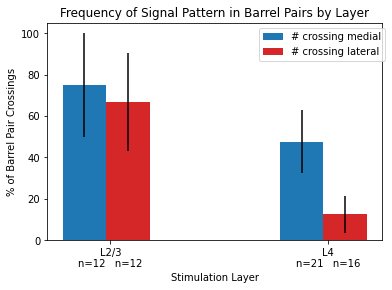

In [12]:
def significance_bar(start,end,height,displaystring,linewidth = 1.2,markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),height,displaystring,ha = 'center',va='center',bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad)),size = fontsize)

n_L23 = {'medial' : data['L2/3']["Medial"]['total'],
         'lateral' : data['L2/3']["Lateral"]['total']}
n_L4 = {'medial' : data['L4']["Medial"]['total'],
         'lateral' : data['L4']["Lateral"]['total']}
n_L5 = {'medial' : data['L5']["Medial"]['total'],
        'lateral' : data['L5']["Lateral"]['total']}

plt.clf()
i = 0
tick_labels = []
colors = {"# crossing medial": 'tab:blue', 
          "# crossing lateral": 'tab:red'}
# in format # no crossing, # crossing, # no signal; l2/3, L4, L5

length_of_previous_sl = i

all_layers = ['L2/3', 'L4']
totals = {'medial' : [], 'lateral': [] }
for med in ['medial', 'lateral']:
    if n_L23[med] > 0:
        totals[med].append(n_L23[med])
    if n_L4[med] > 0:
        totals[med].append(n_L4[med])
    if n_L5[med] > 0:
        totals[med].append(n_L5[med])


# in columns L23, L4, L5
crossing_data = {
    '# crossing medial': [data[x]['Medial']['n_barrel_cross'] for x in all_layers],
    '# crossing lateral': [data[x]['Lateral']['n_barrel_cross'] for x in all_layers]
}
errbars = {}
for k in crossing_data:
    errbars[k] = [np.sqrt(x) for x in crossing_data[k]]
    med = 'lateral'
    if 'medial' in k:
        med = 'medial'
    for j in range(len(errbars[k])):
        print(errbars[k][j], totals[med][j])
        errbars[k][j] /= totals[med][j] / 100
        crossing_data[k][j] /= totals[med][j] / 100 

labels = [x for x in crossing_data.keys()]
#tick_labels += [all_layers['medial'][j] + "\n(n="+str(totals['medial'][j]) + ")"
#                            for j in range(len(all_layers))]
#tick_labels += [all_layers['lateral'][j] + "\n(n="+str(totals['lateral'][j]) + ")"
#                            for j in range(len(all_layers))]

tick_labels = ['L2/3\nn=' + str(n_L23['medial'])
                   + "   n=" + str(n_L23['lateral']),
               'L4\nn=' + str(n_L4['medial'])
                   + "   n=" + str(n_L4['lateral'])]
#,
#              'L5\nn=' + str(n_L5['medial'])
#                   + "   n=" + str(n_L5['lateral'])]

print(errbars)
print(crossing_data)

# This is a binomial experiment of n independent trials.
# We use the Binomial case of goodness of fit test to a 
# chi-squared distribution
pvals = []
for med in ['medial', 'lateral']:
    for i in range(2):
        layer = ['L2/3', 'L4', 'L5'][i]
        n = [n_L23[med], n_L4[med], n_L5[med]][i]
        cr = crossing_data['# crossing ' + med][i]
        k = n * cr / 100 # number of crosses

        null_hyp_p = 0.5

        pval = binom_test(k, n, null_hyp_p, alternative='two-sided')
        print("Binomial test pval for dir " + med + ", layer", 
              layer, ":", pval)
        pvals.append(pval)
    
##########################
for nm in crossing_data:
    x = np.arange(len(all_layers))
    # else:
    plt.bar(x + (i-1) * 0.2, 
        crossing_data[nm],
        0.2,
        label=(nm if length_of_previous_sl == 0 else None),
        color=colors[nm])
    plt.errorbar(x + (i-1) * 0.2, 
                crossing_data[nm],
                yerr=errbars[nm],
                fmt='none',
                color='black')
    i += 1

#for i in range(3):
    #if pvals[i] < 0.001:
        #significance_bar(i-.5, i+0.25, 20, "P<0.001", fontsize=10)
    
plt.title("Frequency of Signal Pattern in Barrel Pairs by Layer")
plt.xlabel("Stimulation Layer")
plt.ylabel("% of Barrel Pair Crossings")
#plt.xticks(rotation='vertical')
plt.xticks(np.arange(0.12,len(tick_labels)+0.12), tick_labels)
plt.legend(bbox_to_anchor=(0.82, 1.0), loc='upper center')
plt.savefig(data_dir + "results_count-medial_oct2023.png")
plt.show()

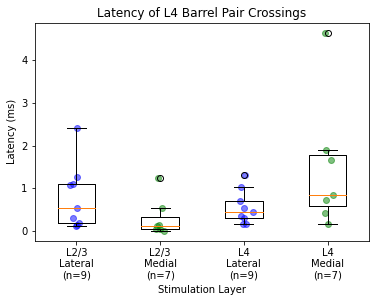

In [13]:
# latency plots
plt.clf()
i = 1
xtick_labels = []
df_datasets = []
for stim_loc in ['L2/3', 'L4']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    df_medial3 = df2[df2["Most Medial Barrel"] == 3]
    df_medial1 = df2[df2["Most Medial Barrel"] == 1]
    medial_lat = []
    lateral_lat = []
    medial_lat.append(df_medial1[(df_medial1['abs(delta 2)'] > 0) 
                                   & (df_medial1['Stim Barrel'] == 3)]['abs(delta 2)'])
    lateral_lat.append(df_medial3[(df_medial3['abs(delta 2)'] > 0)
                                   & (df_medial3['Stim Barrel'] == 3)]['abs(delta 2)'])
    medial_lat.append(df_medial3[(df_medial3['abs(delta 2)'] > 0)
                                   & (df_medial3['Stim Barrel'] == 2)]['abs(delta 2)'])
    lateral_lat.append(df_medial3[(df_medial3['abs(delta 1)'] > 0)
                                   & (df_medial3['Stim Barrel'] == 2)]['abs(delta 1)'])
    medial_lat.append(df_medial3[(df_medial3['abs(delta 1)'] > 0)
                                   & (df_medial3['Stim Barrel'] == 1)]['abs(delta 1)'])
    lateral_lat.append(df_medial1[(df_medial1['abs(delta 1)'] > 0)
                                   & (df_medial1['Stim Barrel'] == 1)]['abs(delta 1)'])
    medial_lat.append(df_medial1[(df_medial1['abs(delta 1)'] > 0) 
                                   & (df_medial1['Stim Barrel'] == 2)]['abs(delta 1)'])
    lateral_lat.append(df_medial1[(df_medial1['abs(delta 2)'] > 0) 
                                   & (df_medial1['Stim Barrel'] == 2)]['abs(delta 2)'])
    
    medial_lat = pd.concat(medial_lat)
    lateral_lat = pd.concat(lateral_lat)
    
    #dfd1_ant = df2_ant['abs(delta 1)'].dropna()
    #dfd2_ant = df2_ant['abs(delta 2)'].dropna()
    
    #df2_post = df2[df2['Slice Location'] == "Posterior"]
    #dfd1_post = df2_post['abs(delta 1)'].dropna()
    #dfd2_post = df2_post['abs(delta 2)'].dropna()
    
    #dfds_ant = np.concatenate([dfd1_ant, dfd2_ant])
    #dfds_post = np.concatenate([dfd1_post, dfd2_post])
    
    jittered_xs_1 = np.random.normal(i, 0.04, lateral_lat.shape[0])
    jittered_xs_2 = np.random.normal(i+1, 0.04, medial_lat.shape[0])
    plt.scatter(jittered_xs_1, lateral_lat, alpha=0.5, color='blue')
    plt.scatter(jittered_xs_2, medial_lat, alpha=0.5, color='green')

    xtick_labels.append(stim_loc + "\nLateral\n(n=" + str(len(lateral_lat)) +")")
    df_datasets.append(lateral_lat)
    xtick_labels.append(stim_loc + "\nMedial\n(n=" + str(len(medial_lat)) +")")
    df_datasets.append(medial_lat)
    i += 2

"""# calculate significance
for sl1 in ['ant', 'post']:
    for sl2 in ['ant', 'post']:
        for la1 in ['L2/3', 'L4', 'L5']:
            for la2 in ['L2/3', 'L4', 'L5']:
                if sl1 == sl2 and la1 == la2:
                    continue
                elif len(dists[sl1][la1]) < 3 or len(dists[sl2][la2]) < 3:
                    continue
                else:
                    p_val = kstest(dists[sl1][la1], dists[sl2][la2]).pvalue
                    if p_val < 0.05:
                        print('KS test for ' + sl1 + " layer " + la1 + " and", 
                              sl2 + " layer " + la2,
                             "is significant with p-value ", p_val)
"""
# significance: L2/3 Rostral and L4 Rostral, and 
#               L2/3 Rostral and L4 Caudal
#significance_bar(0.75, 2.25, 3.35, "P<0.05", fontsize=10)

plt.boxplot(df_datasets)
plt.xticks(range(1, len(xtick_labels)+1), xtick_labels)
plt.title("Latency of L4 Barrel Pair Crossings")
plt.xlabel("Stimulation Layer")
plt.ylabel("Latency (ms)")
plt.savefig(data_dir + cell_type_prefix + "_results_latency_medial-bias_" + str(datetime.date.today()) +".png", bbox_inches="tight")
plt.show()


KS test p-value  0.3620106185909979


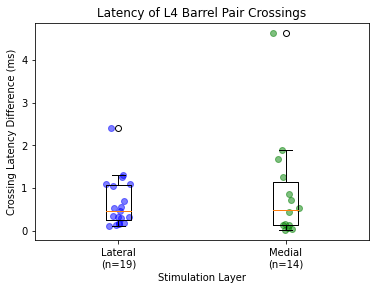

In [17]:
# Lump layers together
# latency plots
plt.clf()
i = 1
xtick_labels = []
df_datasets = []
df2 = df
df_medial3 = df2[df2["Most Medial Barrel"] == 3]
df_medial1 = df2[df2["Most Medial Barrel"] == 1]
    
medial_lat = []
lateral_lat = []
medial_lat.append(df_medial1[(df_medial1['abs(delta 2)'] > 0) 
                               & (df_medial1['Stim Barrel'] == 3)]['abs(delta 2)'])
lateral_lat.append(df_medial3[(df_medial3['abs(delta 2)'] > 0)
                               & (df_medial3['Stim Barrel'] == 3)]['abs(delta 2)'])
medial_lat.append(df_medial3[(df_medial3['abs(delta 2)'] > 0)
                               & (df_medial3['Stim Barrel'] == 2)]['abs(delta 2)'])
lateral_lat.append(df_medial3[(df_medial3['abs(delta 1)'] > 0)
                               & (df_medial3['Stim Barrel'] == 2)]['abs(delta 1)'])
medial_lat.append(df_medial3[(df_medial3['abs(delta 1)'] > 0)
                               & (df_medial3['Stim Barrel'] == 1)]['abs(delta 1)'])
lateral_lat.append(df_medial1[(df_medial1['abs(delta 1)'] > 0)
                               & (df_medial1['Stim Barrel'] == 1)]['abs(delta 1)'])
medial_lat.append(df_medial1[(df_medial1['abs(delta 1)'] > 0) 
                               & (df_medial1['Stim Barrel'] == 2)]['abs(delta 1)'])
lateral_lat.append(df_medial1[(df_medial1['abs(delta 2)'] > 0) 
                               & (df_medial1['Stim Barrel'] == 2)]['abs(delta 2)'])

medial_lat = pd.concat(medial_lat)
lateral_lat = pd.concat(lateral_lat)

#dfd1_ant = df2_ant['abs(delta 1)'].dropna()
#dfd2_ant = df2_ant['abs(delta 2)'].dropna()

#df2_post = df2[df2['Slice Location'] == "Posterior"]
#dfd1_post = df2_post['abs(delta 1)'].dropna()
#dfd2_post = df2_post['abs(delta 2)'].dropna()

#dfds_ant = np.concatenate([dfd1_ant, dfd2_ant])
#dfds_post = np.concatenate([dfd1_post, dfd2_post])

jittered_xs_1 = np.random.normal(i, 0.04, lateral_lat.shape[0])
jittered_xs_2 = np.random.normal(i+1, 0.04, medial_lat.shape[0])
plt.scatter(jittered_xs_1, lateral_lat, alpha=0.5, color='blue')
plt.scatter(jittered_xs_2, medial_lat, alpha=0.5, color='green')

xtick_labels.append("Lateral\n(n=" + str(len(lateral_lat)) +")")
df_datasets.append(lateral_lat)
xtick_labels.append("Medial\n(n=" + str(len(medial_lat)) +")")
df_datasets.append(medial_lat)

p_val = kstest(medial_lat, lateral_lat).pvalue
print("KS test p-value ", p_val)

# significance: L2/3 Rostral and L4 Rostral, and 
#               L2/3 Rostral and L4 Caudal
#significance_bar(0.75, 2.25, 3.35, "P<0.05", fontsize=10)

plt.boxplot(df_datasets)
plt.xticks(range(1, len(xtick_labels)+1), xtick_labels)
plt.title("Latency of L4 Barrel Pair Crossings")
plt.xlabel("Stimulation Layer")
plt.ylabel("Crossing Latency Difference (ms)")
plt.savefig(data_dir + cell_type_prefix + "_results_latency_medial-bias_" + str(datetime.date.today()) +".png", bbox_inches="tight")
plt.show()


0.6907000000000001 +/- 0.6193717033600074
1.028032 +/- 1.0011922707332492
KS test p-value  0.4475725833721871


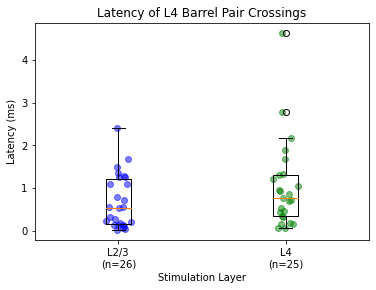

In [16]:
# Now do ALL latencies and see if there are any multimodal distributions
plt.clf()
i = 1
xtick_labels = []
df_datasets = []
df = pd.read_csv(data_dir + csv_prefix)
df = pd.DataFrame(df)
df = df[df["Exclude Reason"].isnull()]
for stim_loc in ['L2/3', 'L4']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    
    df_d1 = df2[df2['abs(delta 1)'] > 0]['abs(delta 1)']
    df_d2 = df2[df2['abs(delta 2)'] > 0]['abs(delta 2)']
    df_lat = pd.concat([
        df_d1, df_d2
    ])
    jittered_xs_1 = np.random.normal(i, 0.04, df_lat.shape[0])
    plt.scatter(jittered_xs_1, df_lat, alpha=0.5, color={"L2/3" : 'blue', "L4": "green"}[stim_loc])

    xtick_labels.append(stim_loc + "\n(n=" + str(len(df_lat)) +")")
    df_datasets.append(df_lat)
    i += 1
    print(np.mean(df_lat), "+/-", np.std(df_lat))

p_val = kstest(df_datasets[0], df_datasets[1]).pvalue
print("KS test p-value ", p_val)
# significance: L2/3 Rostral and L4 Rostral, and 
#               L2/3 Rostral and L4 Caudal
#significance_bar(0.75, 2.25, 3.35, "P<0.05", fontsize=10)
plt.boxplot(df_datasets)
plt.xticks(range(1, len(xtick_labels)+1), xtick_labels)
plt.title("Latency of L4 Barrel Pair Crossings")
plt.xlabel("Stimulation Layer")
plt.ylabel("Latency (ms)")
plt.savefig(data_dir + cell_type_prefix + "_results_latency_medial-bias_" + str(datetime.date.today()) +".png", bbox_inches="tight")
plt.show()
